In [1]:
from __future__ import print_function

from IPython import display

import math
import matplotlib
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import radians, cos, sin, arcsin, arccos, sqrt, pi, arctan2, degrees, arctan
import itertools

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
tqdm.pandas(tqdm_notebook)

import osrm
from joblib import dump, load

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from natsort import natsorted
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import metrics

from xgboost import XGBRegressor

pd.options.display.max_rows = 10

In [2]:
df = pd.read_csv('all.tsv', delim_whitespace=True, header =None, parse_dates=[1])
df.columns = ['trip id','iso timestamp','latitude','longitude']
grouper = df.groupby('trip id')

In [ ]:
# pd.to_datetime(df['iso timestamp'])

In [3]:
tripid = df["trip id"].unique()
tracks_dict = {elem: pd.DataFrame for elem in tripid}

In [ ]:
for key in tqdm(tracks_dict.keys()):
        tracks_dict[key] = df[:][df["trip id"] == key] # [:] equal to .loc[:, tracks["name"]]

In [ ]:
tracks_dict[100].plot(x = 'latitude', y = 'longitude')

  3%|▎         | 800/24999 [00:16<11:06, 36.33it/s]

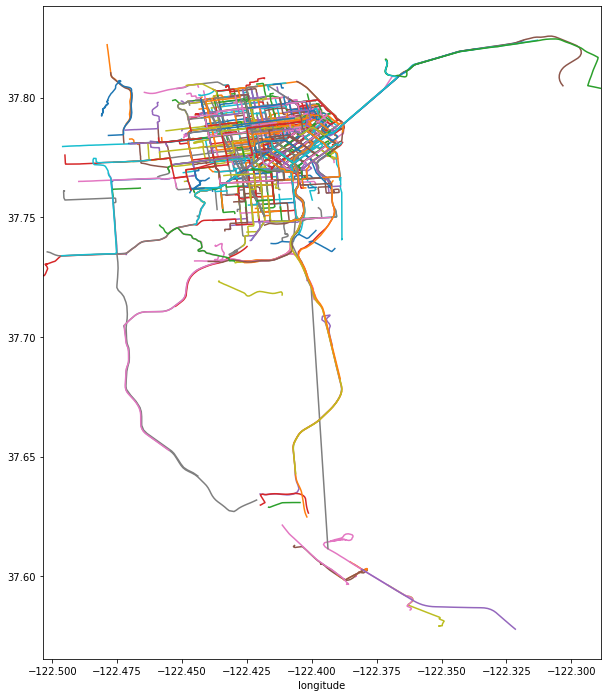

  3%|▎         | 800/24999 [00:29<11:06, 36.33it/s]

In [4]:
i = 0
fig, ax = plt.subplots()
for name, val in tqdm(grouper):
    val.plot('longitude', 'latitude', ax= ax, legend = False, figsize = (10,12))
    i+= 1
    if i >800:
        break

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    #ensure using numpy and not math, or pandas series cannot be passed
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a))
    r = 6378.137 ##radius of earth km
    return c * r

def compute_dist(df):
    next_df = df.shift(1)
    dist = haversine(df.iloc[:,0], df.iloc[:,1],
                    next_df.iloc[:,0], next_df.iloc[:,1])
    return dist

def compute_time(df):
    next_df = df.shift(1)
#     df["time"] = pd.to_datetime(df["time_utc"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise')
    timedelt = df["iso timestamp"] - next_df["iso timestamp"]
    return timedelt

def compute_speed(df):
    kinematics = df.copy()
    kinematics["distance_travelled"] = compute_dist(kinematics[["latitude", "longitude"]].astype(float)).values
    kinematics["time_elapsed"] = compute_time(kinematics).values
    kinematics["time_elapsed_seconds"] = kinematics["time_elapsed"]/np.timedelta64(1,'s')
    kinematics["speed m/s"] = (kinematics["distance_travelled"]*1000)/kinematics["time_elapsed_seconds"]
    kinematics["speed kmh"] = kinematics["speed m/s"]*3.6
    kinematics.drop(columns = ['time_elapsed'], inplace = True)
    kinematics.fillna(0, inplace = True)
#     df["distance_travelled"] = kinematics["distance_travelled"].values
#     df["speed kmh"] = kinematics["speed kmh"].values
    return kinematics

def cal_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates the bearing between two points using the formula
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    """
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1

    x = sin(dlon) * cos(lat2)
    y1 = cos(lat1) * sin(lat2)
    y2 = sin(lat1) * cos(lat2) * cos(dlon)
    y = y1 - y2

    initial_bearing = arctan2(x, y)

    initial_bearing = degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [ ]:
df2 = tracks_dict[123].copy()
import time


In [ ]:
start = time.time()

df3 = compute_speed(df2)

end = time.time()
print(end - start)

In [50]:
df3

,trip id,iso timestamp,latitude,longitude,distance_travelled,time_elapsed_seconds,speed m/s,speed kmh
5106,123,2007-01-01 08:10:52+00:00,37.788836,-122.419344,0.000000,0.0,0.000000,0.000000
5107,123,2007-01-01 08:10:56+00:00,37.788919,-122.418721,0.055580,4.0,13.895117,50.022422
5108,123,2007-01-01 08:11:00+00:00,37.788987,-122.418147,0.051061,4.0,12.765153,45.954552
5109,123,2007-01-01 08:11:04+00:00,37.789051,-122.417605,0.048211,4.0,12.052636,43.389488
5110,123,2007-01-01 08:11:08+00:00,37.789094,-122.417297,0.027515,4.0,6.878787,24.763633
...,...,...,...,...,...,...,...,...
5141,123,2007-01-01 08:13:28+00:00,37.779994,-122.415214,0.021620,4.0,5.404959,19.457852
5142,123,2007-01-01 08:13:44+00:00,37.779392,-122.415000,0.069609,16.0,4.350572,15.662060
5143,123,2007-01-01 08:13:48+00:00,37.778906,-122.414729,0.059123,4.0,14.780634,53.210282
5144,123,2007-01-01 08:13:52+00:00,37.778776,-122.414709,0.014578,4.0,3.644532,13.120315


In [5]:
#Trip Creation

taxi1 = []
col_names = ['trip_id', 'pickup_datetime','pickup_latitude', 'pickup_longitude'
             ,'dropoff_datetime','dropoff_latitude', 'dropoff_longitude']
for name, val in tqdm(grouper):
    trip = []
    trip.append(name)
    trip.append(val['iso timestamp'].iloc[0])
    trip.append(val['latitude'].iloc[0])
    trip.append(val['longitude'].iloc[0])
    trip.append(val['iso timestamp'].iloc[-1])
    trip.append(val['latitude'].iloc[-1])
    trip.append(val['longitude'].iloc[-1])

    taxi1.append(trip)

100%|██████████| 24999/24999 [00:15<00:00, 1664.56it/s]


In [6]:
taxi = pd.DataFrame(taxi1, columns = col_names)

In [7]:
taxi = taxi[taxi['dropoff_latitude'] < 37.85]
taxi = taxi[taxi['dropoff_latitude'] > 37.70]
taxi = taxi[taxi['dropoff_longitude'] < -122.35]
# taxi = taxi[taxi['dropoff_longitude'] > -74.0096]

taxi = taxi[taxi['pickup_latitude'] < 37.85]
taxi = taxi[taxi['pickup_latitude'] > 37.70]
taxi = taxi[taxi['pickup_longitude'] < -122.35]
# taxi = taxi[taxi['pickup_longitude'] > -74.0096]

In [8]:
def coord_prec(coord):
    precision =  math.pow(10, 3)
    new_coord = float((int(precision * coord)))/precision
    return new_coord


In [9]:
def rmsle(ypred, ytest) :
    assert len(ytest) == len(ypred)
    return np.sqrt(np.mean((np.log1p(ypred) - np.log1p(ytest))**2))

In [10]:
df = taxi[["pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude"]].astype(float)
taxi['direct_distance'] = haversine(df.iloc[:,0], df.iloc[:,1],df.iloc[:,2],df.iloc[:,3])
taxi['bearing'] = cal_bearing(df.iloc[:,0], df.iloc[:,1],df.iloc[:,2],df.iloc[:,3])

In [11]:
taxi['pickup_lat_cut'] = taxi.pickup_latitude.apply(coord_prec)
taxi['pickup_lon_cut'] = taxi.pickup_longitude.apply(coord_prec)
taxi['dropoff_lat_cut'] = taxi.dropoff_latitude.apply(coord_prec)
taxi['dropoff_lon_cut'] = taxi.dropoff_longitude.apply(coord_prec)

In [12]:
taxi['pickup_weekday'] = taxi['pickup_datetime'].dt.weekday
taxi['pickup_hour_weekofyear'] = taxi['pickup_datetime'].dt.weekofyear
taxi['pickup_hour'] = taxi['pickup_datetime'].dt.hour
taxi['pickup_minute'] = taxi['pickup_datetime'].dt.minute
taxi['pickup_dt'] = (taxi['pickup_datetime'] - taxi['pickup_datetime'].min()).dt.total_seconds()
taxi['pickup_week_hour'] = taxi['pickup_weekday'] * 24 + taxi['pickup_hour']

In [13]:
coords = np.vstack((taxi[['pickup_latitude', 'pickup_longitude']].values,
                    taxi[['dropoff_latitude', 'dropoff_longitude']].values))
pca = PCA()
pca = pca.fit(coords)
taxi['pickup_pca0'] = pca.transform(taxi[['pickup_latitude', 'pickup_longitude']])[:, 0]
taxi['pickup_pca1'] = pca.transform(taxi[['pickup_latitude', 'pickup_longitude']])[:, 1]
taxi['dropoff_pca0'] = pca.transform(taxi[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
taxi['dropoff_pca1'] = pca.transform(taxi[['dropoff_latitude', 'dropoff_longitude']])[:, 1]


In [14]:
km = KMeans(
    n_clusters=40, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

# km = load('kmeans_0310.joblib')
coordinates = taxi[["pickup_longitude", "pickup_latitude"]].values
pickup_km = km.fit_predict(coordinates)


coordinates = taxi[["dropoff_longitude", "dropoff_latitude"]].values
dropoff_km = km.predict(coordinates)


taxi["pickup_cluster"] = pickup_km
taxi["dropoff_cluster"] = dropoff_km

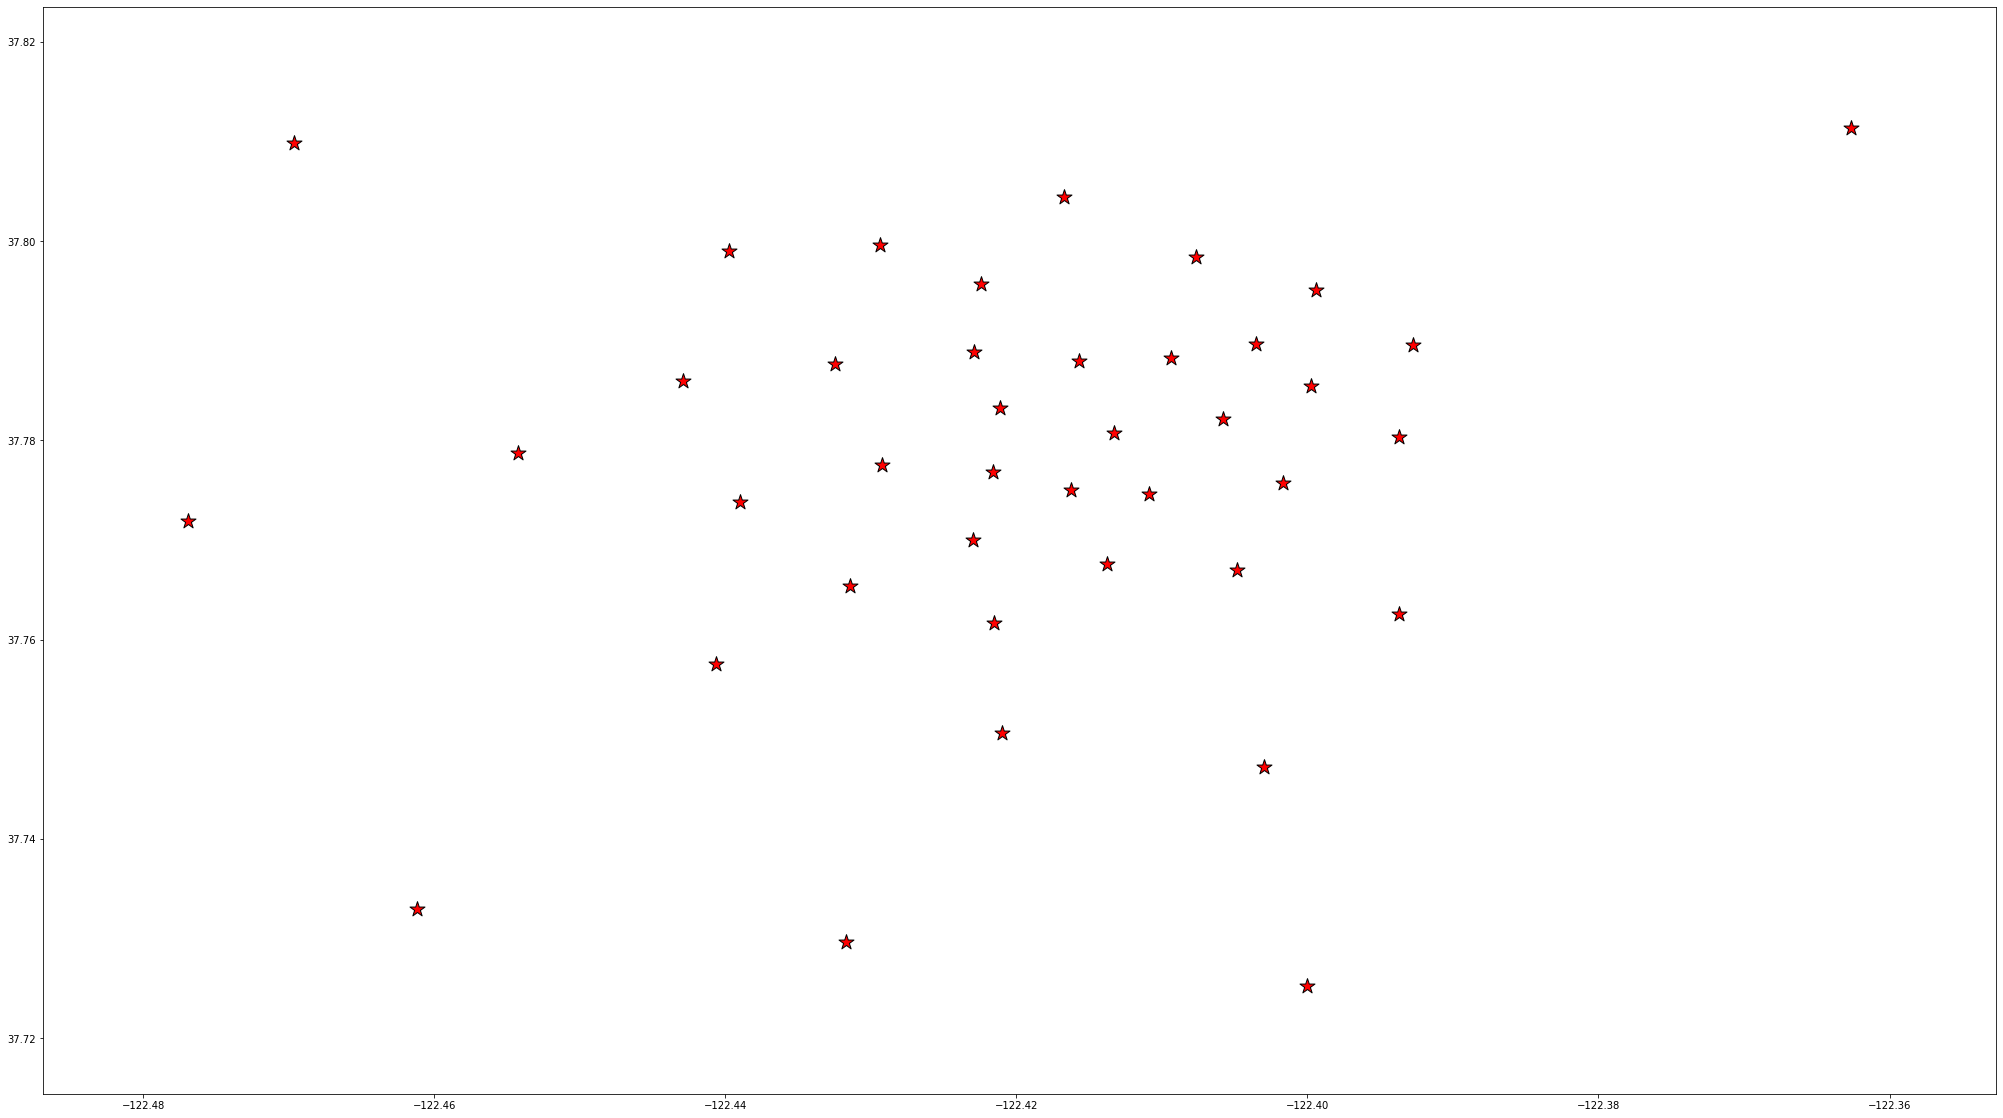

In [15]:
plt.figure(figsize=(35,20))

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], 
            s=250, marker='*', c='red', edgecolor='black',label='centroids')

# plt.scatter(coordinates[:,0], coordinates[:,1], c = pickup_km)

In [16]:
taxi['duration'] = taxi['dropoff_datetime'] - taxi['pickup_datetime']
taxi['duration'] = taxi['duration'].dt.total_seconds().astype(int)

In [17]:
taxi = taxi[taxi['duration'] > 0]
taxi = taxi[taxi['duration'] < 1000]
taxi = taxi[taxi.loc[:, 'direct_distance'] < 100] #100km

taxi = taxi[taxi.loc[:, 'duration'] > 120] #2 minutes
taxi = taxi[taxi.loc[:, 'direct_distance'] > 0.1] #100m

In [18]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    
    #the Haversine version
    foob = df[["pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude"]].astype(float)
    df['hav_dist_lat'] = haversine(foob.iloc[:,0], foob.iloc[:,1],foob.iloc[:,2],foob.iloc[:,1])
    df['hav_dist_lon'] = haversine(foob.iloc[:,2], foob.iloc[:,1],foob.iloc[:,2],foob.iloc[:,3])

add_travel_vector_features(taxi)

### Converting abs_diff_longitude & lattitude to miles...
# Since we are calculating this at New York, we can assign a constant, rather than using a formula
# longitude = degrees of latitude in radians * 69.172
#1 degree of longitude = 50 miles

def convert_km(df):
    df['abs_diff_longitude'] = df.abs_diff_longitude*80.4
    df['abs_diff_latitude'] = df.abs_diff_latitude*111
convert_km(taxi)

In [19]:

### Angle difference between north, and manhattan roadways
meas_ang = 0.506 # 29 degrees = 0.506 radians
import math

## adding extra features
def add_extra_manh_features(df):
    df['Euclidean'] = (df.abs_diff_latitude**2 + df.abs_diff_longitude**2)**0.5 
    
    df['manh_length_hav'] = df.hav_dist_lat + df.hav_dist_lon
    df['manh_length_euc'] = df.abs_diff_latitude + df.abs_diff_longitude
    
    #Angle-corrected Manh distance (Euc)
    df['delta_manh_lon_euc'] = (df.Euclidean*np.sin(np.arctan(df.abs_diff_longitude / df.abs_diff_latitude)-meas_ang)).abs()
    df['delta_manh_lat_euc'] = (df.Euclidean*np.cos(np.arctan(df.abs_diff_longitude / df.abs_diff_latitude)-meas_ang)).abs()
    df['manh_length_euc_corrected'] = df.delta_manh_lon_euc + df.delta_manh_lat_euc
    
    #Angle-corrected Manh distance (Hav)
    df['delta_manh_lon_hav'] = (df.direct_distance*np.sin(np.arctan(df.hav_dist_lon/ df.hav_dist_lat)-meas_ang)).abs()
    df['delta_manh_lat_hav'] = (df.direct_distance*np.cos(np.arctan(df.hav_dist_lon/ df.hav_dist_lat)-meas_ang)).abs()
    df['manh_length_hav_corrected'] = df.delta_manh_lon_hav + df.delta_manh_lat_hav
    
#     df['Euc_diff'] = (df['manh_length_euc'] - df['Euclidean'])*100 /  df['Euclidean']

add_extra_manh_features(taxi)
taxi['minkowski_0.9'] = (taxi.hav_dist_lat**0.92 + taxi.hav_dist_lon**0.92)**(1/0.92)

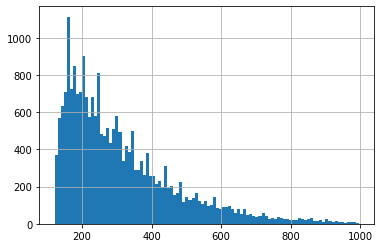

In [20]:
taxi['duration'].hist(bins = 100)

In [21]:
taxi.columns

Index(['trip_id', 'pickup_datetime', 'pickup_latitude', 'pickup_longitude',
       'dropoff_datetime', 'dropoff_latitude', 'dropoff_longitude',
       'direct_distance', 'bearing', 'pickup_lat_cut', 'pickup_lon_cut',
       'dropoff_lat_cut', 'dropoff_lon_cut', 'pickup_weekday',
       'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt',
       'pickup_week_hour', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0',
       'dropoff_pca1', 'pickup_cluster', 'dropoff_cluster', 'duration',
       'abs_diff_longitude', 'abs_diff_latitude', 'hav_dist_lat',
       'hav_dist_lon', 'Euclidean', 'manh_length_hav', 'manh_length_euc',
       'delta_manh_lon_euc', 'delta_manh_lat_euc', 'manh_length_euc_corrected',
       'delta_manh_lon_hav', 'delta_manh_lat_hav', 'manh_length_hav_corrected',
       'minkowski_0.9'],
      dtype='object')

In [74]:
def osrm_dist(foo):
    try:
        result = osrm.simple_route([foo['pickup_longitude'],foo['pickup_latitude']], [foo['dropoff_longitude'], foo['dropoff_latitude']],
                               output='route', overview="full", geometry='wkt')
        result = pd.DataFrame(result)
        return result['distance']/1000
    except:
        pass


In [ ]:
##Testing server response
foo = taxi.iloc[111]
result = osrm.simple_route([foo['pickup_longitude'],foo['pickup_latitude']], [foo['dropoff_longitude'], foo['dropoff_latitude']],
                           output='route', overview="full", geometry='wkt')
result = pd.DataFrame(result)
result

In [ ]:
taxi

In [19]:
# df2['osrm_dist'] = df2.apply(osrm_dist, axis = 1)

In [20]:
import time
start = time.time()

taxi['osrm_dist'] = taxi.progress_apply(osrm_dist, axis = 1)

end = time.time()
print(end - start)

100%|██████████| 24632/24632 [02:17<00:00, 179.01it/s]

137.67336916923523


In [528]:
def osrm_time(df3):
    df3['osrm_dist'] = df3.progress_apply(osrm_dist, axis = 1)
    return df3

In [ ]:
import time
from multiprocessing import Process, Manager, Pool

start = time.time()

df_split = np.array_split(taxi, 4) 
pool = Pool(4, maxtasksperchild=1000)        
df = pd.concat(pool.map(osrm_time,df_split))
pool.close()
pool.join()

end = time.time()
print(end - start)

del df_split
del df2
df2 = df
del df

In [23]:
df2.sort_values(by=['osrm_dist'], inplace=True)
df2['dist_bin'] = pd.cut(df2['osrm_dist'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 20]).astype(str).str.strip('()[]')

In [99]:
taxi.columns

Index(['trip_id', 'pickup_datetime', 'pickup_latitude', 'pickup_longitude',
       'dropoff_datetime', 'dropoff_latitude', 'dropoff_longitude',
       'direct_distance', 'bearing', 'pickup_lat_cut', 'pickup_lon_cut',
       'dropoff_lat_cut', 'dropoff_lon_cut', 'pickup_weekday',
       'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt',
       'pickup_week_hour', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0',
       'dropoff_pca1', 'pickup_cluster', 'dropoff_cluster', 'duration',
       'abs_diff_longitude', 'abs_diff_latitude', 'hav_dist_lat',
       'hav_dist_lon', 'Euclidean', 'manh_length_hav', 'manh_length_euc',
       'minkowski_0.9', 'delta_manh_lon_euc', 'delta_manh_lat_euc',
       'manh_length_euc_corrected', 'delta_manh_lon_hav', 'delta_manh_lat_hav',
       'manh_length_hav_corrected'],
      dtype='object')

In [22]:
x = taxi[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
       'pickup_lat_cut', 'pickup_lon_cut', 'dropoff_lat_cut',
       'dropoff_lon_cut', 'pickup_weekday', 'pickup_hour_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour',
       'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1',
       'pickup_cluster', 'dropoff_cluster', 'abs_diff_longitude', 'abs_diff_latitude', 'hav_dist_lat',
       'hav_dist_lon', 'Euclidean', 'manh_length_hav', 'manh_length_euc',
       'minkowski_0.9', 'Euclidean', 'manh_length_hav', 'manh_length_euc',
       'minkowski_0.9', 'delta_manh_lon_euc', 'delta_manh_lat_euc',
       'manh_length_euc_corrected', 'delta_manh_lon_hav', 'delta_manh_lat_hav',
       'manh_length_hav_corrected']]
y = taxi['duration']

In [23]:
X_train, X_validation, Y_train, Y_validation =  train_test_split(x,y, test_size = 0.2, random_state = 42)

In [24]:
x_train_prescale = X_train.values
x_validation_prescale = X_validation.values

In [25]:
control_scaler_nodist = sklearn.preprocessing.StandardScaler()
x_train = control_scaler_nodist.fit_transform(x_train_prescale)
x_test = control_scaler_nodist.transform(x_validation_prescale)

In [26]:
random_grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
                "min_child_weight" : [ 1, 3, 5, 7 ],
                "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

xg = XGBRegressor(n_estimators = 370)
xg_random = RandomizedSearchCV(estimator = xg, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
xg_random.fit(x_train, Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished
/home/ericlow/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:03:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=370,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_st...
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='warn', n_iter=10, n_jobs=-1,
 

In [27]:
xg_random.best_params_

{'min_child_weight': 5,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.3,
 'colsample_bytree': 0.4}

In [40]:
xg_reg_nodist = XGBRegressor(objective ='reg:squarederror', n_jobs = -1, min_child_weight = 5, max_depth = 4, learning_rate = 0.2,
                      gamma = 0.3, colsample_bytree = 0.4, alpha = 10, n_estimators = 50)

In [41]:
xg_reg_nodist.fit(x_train,Y_train)


/home/ericlow/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.3,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=4, min_child_weight=5, missing=None, n_estimators=50,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [42]:
y_pred = xg_reg_nodist.predict(x_test)
print("MAE: ", metrics.mean_absolute_error(Y_validation, y_pred), "\nRMSLE: ", rmsle(Y_validation, y_pred))

MAE:  72.92117510141185 
RMSLE:  0.30522136043380416


In [ ]:
#extremely verbose way of matching the validation set with the dist_bin found using OSRM for consistency
# scaler.fit_transform(X_validation)
errors_nodist = pd.DataFrame()
tt = []
for bin_name, group in X_validation.merge(Y_validation, left_index=True, right_index=True).groupby(pd.cut(Y_validation, 10)):
#     print(bin_name)
    group.drop('duration', axis = 1, inplace = True)
    y_grp = Y_validation.loc[group.index]
    y_pred = xg_reg_nodist.predict(control_scaler_nodist.transform(group.values))
    
    aa = metrics.mean_absolute_error(y_grp, y_pred)
    bb = rmsle(y_grp, y_pred)
    
    fooh = pd.DataFrame([aa, bb], columns = [bin_name])
    errors_nodist = pd.concat([errors_nodist, fooh], axis = 1)
    
    predict_results = xg_reg_nodist.predict(control_scaler_nodist.transform(group))
    predict_res = pd.DataFrame(predict_results.flatten() - y_grp)
#     print(predict_res.describe())
#     predict_res.hist(bins = 100)
    tt.append(predict_res)
    
display.display(errors_nodist)

In [44]:
errors_nodist

,"(120.125, 208.5]","(208.5, 296.0]","(296.0, 383.5]","(383.5, 471.0]","(471.0, 558.5]","(558.5, 646.0]","(646.0, 733.5]","(733.5, 821.0]","(821.0, 908.5]","(908.5, 996.0]"
0,59.299276,47.408308,64.823415,85.495837,112.504994,130.483983,154.19374,213.459246,248.574107,311.743684
1,0.345906,0.218234,0.247900,0.294926,0.365662,0.388004,0.37527,0.484710,0.442565,0.504869


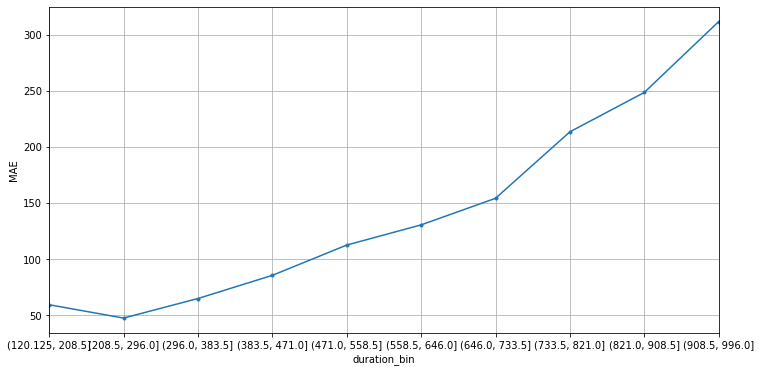

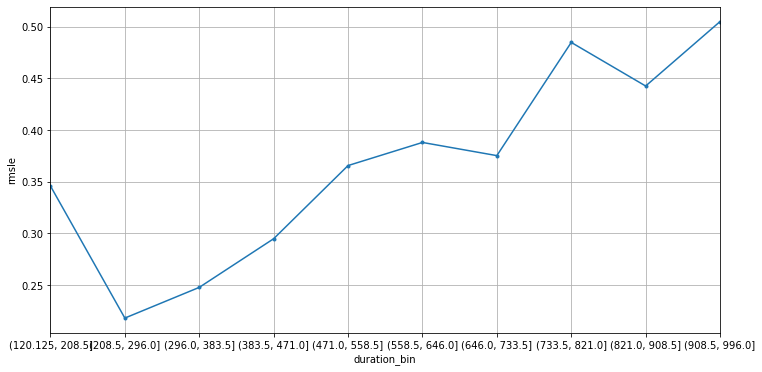

In [45]:
errors_nodist = errors_nodist.rename(index = {0: 'loss_nodist', 1:'rmsle_nodist'})
errors_nodist.loc['loss_nodist'].T.plot(figsize = (12 ,6 ), style ='.-')
plt.xlabel('duration_bin')
plt.ylabel('MAE')
plt.grid(True)
plt.show()
errors_nodist.loc['rmsle_nodist'].T.plot(figsize = (12 ,6 ), style ='.-')
plt.xlabel('duration_bin')
plt.ylabel('rmsle')
plt.grid(True)

In [86]:
from sklearn.externals import joblib


/home/ericlow/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [93]:
bst = joblib.load('021219XGB_full.pkl') 

In [104]:
y_pred = bst.predict(x_test)
print("MAE: ", metrics.mean_absolute_error(Y_validation, y_pred), "\nRMSLE: ", rmsle(Y_validation, y_pred))

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37']
training data did not have the following fields: f36, f37

In [102]:
df3 = pd.read_csv('test.csv', index_col = 0)

In [107]:
df3

,"(53.341, 443.95]","(443.95, 826.9]","(826.9, 1209.85]","(1209.85, 1592.8]","(1592.8, 1975.75]","(1975.75, 2358.7]","(2358.7, 2741.65]","(2741.65, 3124.6]","(3124.6, 3507.55]","(3507.55, 3890.5]","(3890.5, 4273.45]","(4273.45, 4656.4]","(4656.4, 5039.35]","(5039.35, 5422.3]","(5422.3, 5805.25]","(5805.25, 6188.2]","(6188.2, 6571.15]","(6571.15, 6954.1]","(6954.1, 7337.05]","(7337.05, 7720.0]"
loss_nodist,28.951948,41.327290,49.201053,48.423092,87.207037,92.732468,114.179688,113.160327,128.385173,161.219862,417.735245,329.844798,145.397345,57.007573,55.711778,67.395813,77.894909,77.141471,40.175323,95.017978
rmsle_nodist,0.244525,0.140251,0.103020,0.067301,0.097038,0.060969,0.064052,0.057710,0.072209,0.064700,0.148115,0.112433,0.047880,0.018745,0.012739,0.016945,0.014631,0.014132,0.007037,0.023850


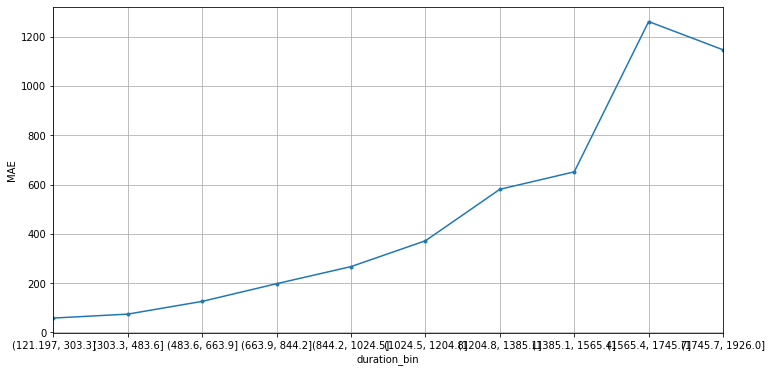

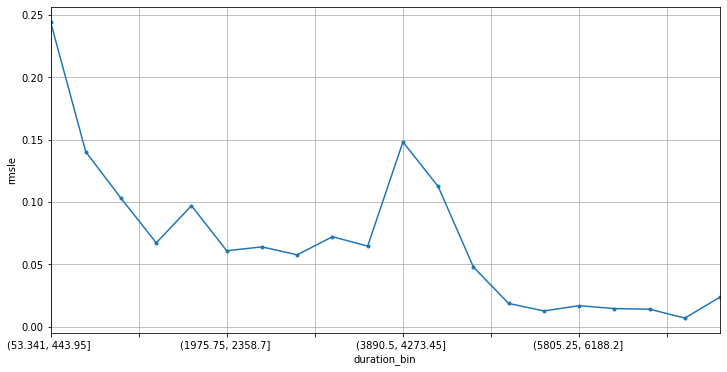

In [127]:
errors_nodist.loc['loss_nodist'].T.plot(figsize = (12 ,6 ), style ='.-')
plt.xlabel('duration_bin')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

df3.loc['rmsle_nodist '].T.plot(figsize = (12 ,6 ), style ='.-')
plt.xlabel('duration_bin')
plt.ylabel('rmsle')
plt.grid(True)

In [123]:

prod = []
for pair in itertools.combinations([1,2,3,4,5,6]
#     tracks_dict[1].iloc[:,1:].values
    ,3):
    prod.append(pair)
    print(pair)
    
# prod = []
# for index in list(itertools.combinations(tracks_dict[1].index,2)):
#     print(index)
# #     print(tracks_dict[1].loc[index,:])

(1, 2)
(1, 3)
(1, 4)
(1, 5)
(2, 3)
(2, 4)
(2, 5)
(3, 4)
(3, 5)
(4, 5)


In [ ]:
taxi2 = []
for name, val in tqdm(grouper):
    prod = []
    for pair in itertools.combinations(val.iloc[:,1:].values,2):
        prod.append(pair)
    try:
        foo = pd.DataFrame.from_records(prod)
        foo = pd.concat([pd.DataFrame(foo[0].values.tolist()), pd.DataFrame(foo[1].values.tolist())], axis = 1)
        taxi2.append(foo)
    except KeyError:
        pass

In [125]:
taxi2[1]

,0,1,2,0,1,2
0,2007-01-06 06:22:35+00:00,37.800224,-122.433520,2007-01-06 06:22:39+00:00,37.800155,-122.434101
1,2007-01-06 06:22:35+00:00,37.800224,-122.433520,2007-01-06 06:22:43+00:00,37.800160,-122.434430
2,2007-01-06 06:22:35+00:00,37.800224,-122.433520,2007-01-06 06:22:47+00:00,37.800378,-122.434527
3,2007-01-06 06:22:35+00:00,37.800224,-122.433520,2007-01-06 06:22:51+00:00,37.800738,-122.434598
4,2007-01-06 06:22:35+00:00,37.800224,-122.433520,2007-01-06 06:22:55+00:00,37.800938,-122.434650
...,...,...,...,...,...,...
148,2007-01-06 06:23:55+00:00,37.800395,-122.436172,2007-01-06 06:24:07+00:00,37.800169,-122.436130
149,2007-01-06 06:23:55+00:00,37.800395,-122.436172,2007-01-06 06:25:03+00:00,37.800066,-122.436167
150,2007-01-06 06:23:59+00:00,37.800228,-122.436116,2007-01-06 06:24:07+00:00,37.800169,-122.436130
151,2007-01-06 06:23:59+00:00,37.800228,-122.436116,2007-01-06 06:25:03+00:00,37.800066,-122.436167



  2%|▏         | 600/24999 [00:22<05:27, 74.51it/s]

In [ ]:
foo = pd.DataFrame.from_records(prod)

In [ ]:
col_names = ['pickup_datetime','pickup_latitude', 'pickup_longitude'
             ,'dropoff_datetime','dropoff_latitude', 'dropoff_longitude']
foo = pd.concat([foo[0].apply(pd.Series), foo[1].apply(pd.Series)], axis = 1)
foo.columns = col_names

In [4]:
taxi2 = []
for name, val in tqdm(grouper):
    taxi2.append(compute_speed(val))

100%|██████████| 24999/24999 [05:42<00:00, 73.08it/s]


In [5]:
foo = pd.concat(taxi2)

In [6]:
foo

,trip id,iso timestamp,latitude,longitude,distance_travelled,time_elapsed_seconds,speed m/s,speed kmh
0,1,2007-01-07 10:54:50+00:00,37.782551,-122.445368,0.000000,0.0,0.000000,0.000000
1,1,2007-01-07 10:54:54+00:00,37.782745,-122.444586,0.072110,4.0,18.027600,64.899359
2,1,2007-01-07 10:54:58+00:00,37.782842,-122.443688,0.079741,4.0,19.935162,71.766582
3,1,2007-01-07 10:55:02+00:00,37.782919,-122.442815,0.077283,4.0,19.320846,69.555047
4,1,2007-01-07 10:55:06+00:00,37.782992,-122.442112,0.062381,4.0,15.595367,56.143321
...,...,...,...,...,...,...,...,...
1128658,25000,2007-01-06 02:37:56+00:00,37.766183,-122.429307,0.005378,4.0,1.344593,4.840535
1128659,25000,2007-01-06 02:38:28+00:00,37.766136,-122.429508,0.018446,32.0,0.576424,2.075126
1128660,25000,2007-01-06 02:38:32+00:00,37.766115,-122.429704,0.017406,4.0,4.351424,15.665126
1128661,25000,2007-01-06 02:38:36+00:00,37.766105,-122.429869,0.014563,4.0,3.640652,13.106348


In [7]:
grouper = foo.groupby('trip id')



  0%|          | 0/24999 [00:00<?, ?it/s]

  0%|          | 1/24999 [00:00<1:08:10,  6.11it/s]

  0%|          | 8/24999 [00:00<49:35,  8.40it/s]  

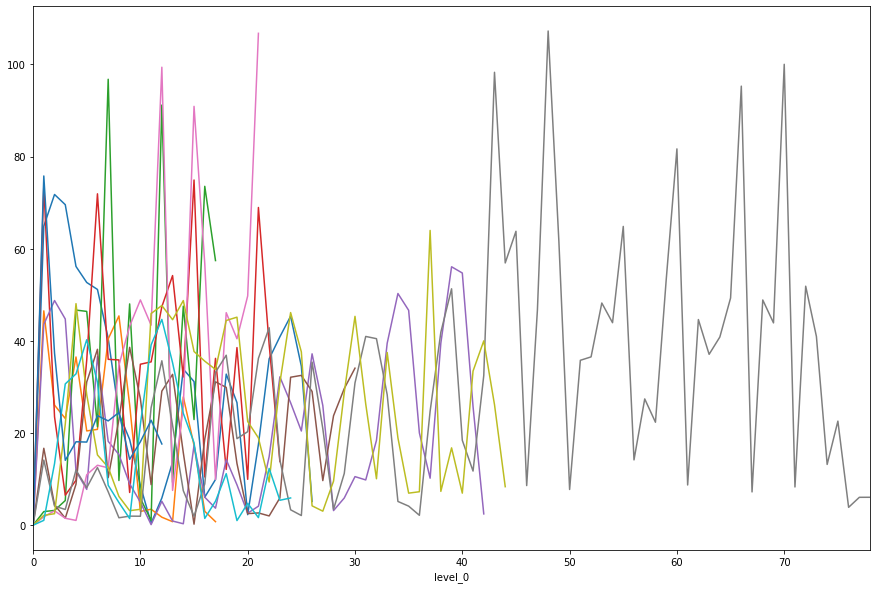

In [20]:
i = 0
fig, ax = plt.subplots()
for name, val in tqdm(grouper):
    val.reset_index().reset_index().plot('level_0','speed kmh', ax= ax, legend = False, figsize = (15,10))
    i+= 1
    if i >10:
        break

In [9]:
foo.to_csv('./all_withspeed.tsv')

In [2]:
df = pd.read_csv('all_withspeed.tsv',parse_dates=[2])
df.drop(df.columns[0], axis=1, inplace = True)

In [3]:
grouper = df.groupby('trip id')

In [4]:
taxi2 = []
for name, val in tqdm(grouper):
    prod = []
    for pair in itertools.combinations(val.iloc[:,1:].values,2):
        prod.append(pair)
    try:
        foo = pd.DataFrame.from_records(prod)
        foo = pd.concat([pd.DataFrame(foo[0].values.tolist()), pd.DataFrame(foo[1].values.tolist())], axis = 1)
        taxi2.append(foo)
    except KeyError:
        pass

100%|██████████| 24999/24999 [05:30<00:00, 75.53it/s] 


In [5]:
dump(taxi2, '/mnt/hgfs/FYP/allpairs_speed')

['/mnt/hgfs/FYP/allpairs_speed']

In [2]:
taxi2 = load('/mnt/hgfs/FYP/allpairs_speed')

In [3]:
taxi2[1]

,0,1,2,3,4,5,6,0,1,2,3,4,5,6
0,2007-01-06 06:22:35+00:00,37.800224,-122.433520,0.000000,0.0,0.000000,0.000000,2007-01-06 06:22:39+00:00,37.800155,-122.434101,0.051678,4.0,12.919610,46.510594
1,2007-01-06 06:22:35+00:00,37.800224,-122.433520,0.000000,0.0,0.000000,0.000000,2007-01-06 06:22:43+00:00,37.800160,-122.434430,0.028944,4.0,7.236004,26.049615
2,2007-01-06 06:22:35+00:00,37.800224,-122.433520,0.000000,0.0,0.000000,0.000000,2007-01-06 06:22:47+00:00,37.800378,-122.434527,0.025724,4.0,6.430954,23.151435
3,2007-01-06 06:22:35+00:00,37.800224,-122.433520,0.000000,0.0,0.000000,0.000000,2007-01-06 06:22:51+00:00,37.800738,-122.434598,0.040559,4.0,10.139675,36.502829
4,2007-01-06 06:22:35+00:00,37.800224,-122.433520,0.000000,0.0,0.000000,0.000000,2007-01-06 06:22:55+00:00,37.800938,-122.434650,0.022729,4.0,5.682216,20.455978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2007-01-06 06:23:55+00:00,37.800395,-122.436172,0.030915,4.0,7.728735,27.823444,2007-01-06 06:24:07+00:00,37.800169,-122.436130,0.006682,8.0,0.835287,3.007033
149,2007-01-06 06:23:55+00:00,37.800395,-122.436172,0.030915,4.0,7.728735,27.823444,2007-01-06 06:25:03+00:00,37.800066,-122.436167,0.011919,56.0,0.212836,0.766211
150,2007-01-06 06:23:59+00:00,37.800228,-122.436116,0.019232,4.0,4.807962,17.308664,2007-01-06 06:24:07+00:00,37.800169,-122.436130,0.006682,8.0,0.835287,3.007033
151,2007-01-06 06:23:59+00:00,37.800228,-122.436116,0.019232,4.0,4.807962,17.308664,2007-01-06 06:25:03+00:00,37.800066,-122.436167,0.011919,56.0,0.212836,0.766211


In [5]:
# fofoo = []
# for name, val in tqdm(grouper):
#     prod = []
#     for pair in itertools.combinations(val.iloc[:,1:].values,2):
#         prod.append(pair)
#     fofoo.append(prod)
# flat_list = [item for sublist in fofoo for item in sublist]
# foo = pd.DataFrame(flat_list)
# foo = pd.concat([pd.DataFrame(foo[0].values.tolist()), pd.DataFrame(foo[1].values.tolist())], axis = 1)    

100%|██████████| 24999/24999 [00:36<00:00, 687.10it/s]


In [ ]:
foo = pd.concat(taxi2)

In [ ]:
col_names = ['pickup_datetime','pickup_latitude', 'pickup_longitude'
         ,'dropoff_datetime','dropoff_latitude', 'dropoff_longitude']
# foo = pd.concat([foo[0].progress_apply(pd.Series), foo[1].apply(pd.Series)], axis = 1)
# foo = pd.concat([pd.DataFrame(foo[0].values.tolist()), pd.DataFrame(foo[1].values.tolist())], axis = 1)
foo.columns = col_names

In [ ]:
foo.to_csv('./allpairs.csv')

In [ ]:
foo.sample(10000).plot(x = 'pickup_latitude', y = 'pickup_longitude')

In [ ]:
chunk = 0
taxi = []
for df in pd.read_csv('allpairs.csv', chunksize = 1000000):
    taxi.append(df)
    chunk += 1
    if chunk == 5:
        break
    

In [ ]:
df = pd.read_csv('allpairs.csv')

In [ ]:
df2 = df.sample(frac = 1)

In [ ]:
df2.to_csv('/mnt/hgfs/FYP/allpairs_shuffled.csv')